# 9. Beta diversity

In [22]:
# Load diversity libraries
library(tidyverse)
library(data.table)
library(reshape2)
library(ggplot2)
library(RColorBrewer)
library(vegan) 
library(phyloseq) 
library(dplyr) 
library(ggpubr) 
library(Hmisc) 
library(corrplot)
library(scales)
library(broom)
library(ecodist) 
library(rstatix)
library(multcompView)
library(patchwork)
library(gridExtra)

In [23]:
# Load rarefied data and filtered metadata
setwd("/home/strawberry/Documents/Collaborations/sinusite_edwin/data")

rarefied_data <- read.delim("./rarefied_data.tsv")
metadata_filtered <- read.delim("./metadata_filtered_Diversity.tsv")

head(rarefied_data)
head(metadata_filtered)

,X.Enterobacter.,X.Eubacterium..sulci.group,X.Eubacterium..yurii.group,X.Ruminococcus..gnavus.group,Abiotrophia,Acetoanaerobium,Achromobacter,Acidaminococcus,Acidibacter,Acidiferrimicrobium,⋯,Veillonella,Vibrio,Virgibacillus,W5053,Williamsia,Xanthobacter,Xenorhabdus,Xylophilus,Yersinia,Yokenella
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0001967K_T1,0,0,0,0,0,0,0,0,0,0,⋯,9,0,0,0,0,0,0,0,0,0
0001967K_T3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0001967K_T6,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0088303G_T0,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0088303G_T1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0088303G_T3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


,ID_Sample,SNOT22,SNOT22nasal,LK_Total,LK_Secret,ClinicCtrl,AntUse,Cortuse,Patient,Filename,⋯,Timepoint,Sex,Age,Atopic_Symptoms,Asthma,NSAID_Intolerance,Total_IgE,Blood_Eosinophilia,Tissue_Eosinophilia,Final_LundMackay
,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<chr>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>
1,0001967K_T1,38,12,4,2,NC,1,1,0001967K,0001967K_T1.fastq,⋯,T1,1,58.7,1,1,0,38,100,10,15
2,0001967K_T3,96,26,10,4,NC,1,0,0001967K,0001967K_T3.fastq,⋯,T3,1,58.7,1,1,0,38,100,10,15
3,0001967K_T6,79,19,6,4,NC,1,1,0001967K,0001967K_T6.fastq,⋯,T6,1,58.7,1,1,0,38,100,10,15
4,0088303G_T0,102,37,8,2,NC,NA,0,0088303G,0088303G_T0.fastq,⋯,T0,2,60.3,1,1,0,667,800,58,22
5,0088303G_T1,32,7,4,1,NC,1,0,0088303G,0088303G_T1.fastq,⋯,T1,2,60.3,1,1,0,667,800,58,22
6,0088303G_T3,NA,NA,NA,NA,NA,0,0,0088303G,0088303G_T3.fastq,⋯,T3,2,60.3,1,1,0,667,800,58,22


In [24]:
# Creating the relative abundance df
## Convert row names to a new column (Sample_ID)
rarefied_data2 <- rarefied_data %>% 
  tibble::rownames_to_column(var = "Sample_ID")

## Compute total reads per sample
total_reads <- rowSums(rarefied_data2[ , -1]) # except for the first column, with the sample codes

## Calculate relative abundance
relative_abundance <- rarefied_data2
relative_abundance[ , -1] <- sweep(rarefied_data2[ , -1], 1, total_reads, FUN = "/") * 100

## Reshape the data to have genus names as the first column
relative_abundance <- relative_abundance %>% 
  pivot_longer(-Sample_ID, names_to = "Taxa", values_to = "Relative_Abundance") %>% 
  pivot_wider(names_from = "Sample_ID", values_from = "Relative_Abundance")

head(relative_abundance)
write.table(relative_abundance, file = "relative_abundance.tsv", sep = "\t", row.names = FALSE)

Taxa,0001967K_T1,0001967K_T3,0001967K_T6,0088303G_T0,0088303G_T1,0088303G_T3,0110059G_T0,0110059G_T12,0110059G_T3,⋯,1628845C_T1,1628845C_T3,1628845C_T6,1645117H_T0,1645117H_T1,1654702B_T0,1654702B_T1,1654702B_T6,1668337K_T0,1668337K_T1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X.Enterobacter.,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
X.Eubacterium..sulci.group,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
X.Eubacterium..yurii.group,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
X.Ruminococcus..gnavus.group,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Abiotrophia,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Acetoanaerobium,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [25]:
## Calculates Bray-Curtis distances between samples
bray_curtis_dist <- vegan::vegdist(t(relative_abundance[, -1]), method = "bray")
bray_curtis_pcoa <- ecodist::pco(bray_curtis_dist) # Performs Principal Coordinate Analysis (PCoA) on the Bray-Curtis dissimilarity matrix to obtain principal coordinate axes
head(bray_curtis_dist)
head(bray_curtis_pcoa)

[1] 0.018 0.018 0.128 0.018 0.123 0.958

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0001967K_T1,-0.22426606,0.040730074,-0.056779926,0.03697908,0.023740540,-0.029376872,-0.008851541,-0.005030971,0.0066989444,0.005570437,⋯,0,0,0,0,0,0,0,0,0,0
0001967K_T3,-0.22850257,0.038406145,-0.058808235,0.04538157,0.025891595,-0.035207075,-0.006119599,-0.005192758,0.0088108479,0.007544306,⋯,0,0,0,0,0,0,0,0,0,0
0001967K_T6,-0.22850257,0.038406145,-0.058808235,0.04538157,0.025891595,-0.035207075,-0.006119599,-0.005192758,0.0088108479,0.007544306,⋯,0,0,0,0,0,0,0,0,0,0
0088303G_T0,-0.20898406,0.002611263,0.022388902,-0.02017153,-0.012995254,-0.066395732,-0.045983672,-0.001529288,-0.0059635848,-0.024844720,⋯,0,0,0,0,0,0,0,0,0,0
0088303G_T1,-0.22850257,0.038406145,-0.058808235,0.04538157,0.025891595,-0.035207075,-0.006119599,-0.005192758,0.0088108479,0.007544306,⋯,0,0,0,0,0,0,0,0,0,0
0088303G_T3,-0.21856518,0.026392487,-0.039181736,0.01980840,0.009287327,0.003069837,0.006483655,-0.001223188,0.0063489825,0.002360290,⋯,0,0,0,0,0,0,0,0,0,0
0110059G_T0,0.53124170,-0.423489460,-0.211753933,-0.24829113,-0.028679339,0.190304341,0.027823402,0.068462541,0.0261729446,-0.080045977,⋯,0,0,0,0,0,0,0,0,0,0
0110059G_T12,-0.17314164,-0.021769997,0.035347746,-0.08097812,-0.054658888,0.148292856,0.055793300,0.030727532,0.0241157137,-0.024609894,⋯,0,0,0,0,0,0,0,0,0,0
0110059G_T3,0.22122676,-0.329056268,0.009212395,-0.28567301,-0.086169700,0.092140368,-0.030773006,-0.023530175,-0.0156227372,0.028085385,⋯,0,0,0,0,0,0,0,0,0,0


In [26]:
### Creates a df to store the PCoA results and assigns the first three principal coordinate axes to columns in the data frame
bray_curtis_pcoa_df <- data.frame(pcoa1 = bray_curtis_pcoa$vectors[,1], 
                                  pcoa2 = bray_curtis_pcoa$vectors[,2],
                                  pcoa3 = bray_curtis_pcoa$vectors[,3]) 
bray_curtis_pcoa_df$ID_Sample <- colnames(relative_abundance)[-1] # Assigns sample IDs as a new column in the data frame
dist_metadata <- merge(metadata_filtered, bray_curtis_pcoa_df, by = "ID_Sample") # Merges the metadata with the PCoA results based on sample IDs.
head(bray_curtis_pcoa_df)
head(dist_metadata)

,pcoa1,pcoa2,pcoa3,ID_Sample
,<dbl>,<dbl>,<dbl>,<chr>
1,-0.2242661,0.040730074,-0.05677993,0001967K_T1
2,-0.2285026,0.038406145,-0.05880824,0001967K_T3
3,-0.2285026,0.038406145,-0.05880824,0001967K_T6
4,-0.2089841,0.002611263,0.02238890,0088303G_T0
5,-0.2285026,0.038406145,-0.05880824,0088303G_T1
6,-0.2185652,0.026392487,-0.03918174,0088303G_T3


,ID_Sample,SNOT22,SNOT22nasal,LK_Total,LK_Secret,ClinicCtrl,AntUse,Cortuse,Patient,Filename,⋯,Atopic_Symptoms,Asthma,NSAID_Intolerance,Total_IgE,Blood_Eosinophilia,Tissue_Eosinophilia,Final_LundMackay,pcoa1,pcoa2,pcoa3
,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,0001967K_T1,38,12,4,2,NC,1,1,0001967K,0001967K_T1.fastq,⋯,1,1,0,38,100,10,15,-0.2242661,0.040730074,-0.05677993
2,0001967K_T3,96,26,10,4,NC,1,0,0001967K,0001967K_T3.fastq,⋯,1,1,0,38,100,10,15,-0.2285026,0.038406145,-0.05880824
3,0001967K_T6,79,19,6,4,NC,1,1,0001967K,0001967K_T6.fastq,⋯,1,1,0,38,100,10,15,-0.2285026,0.038406145,-0.05880824
4,0088303G_T0,102,37,8,2,NC,NA,0,0088303G,0088303G_T0.fastq,⋯,1,1,0,667,800,58,22,-0.2089841,0.002611263,0.02238890
5,0088303G_T1,32,7,4,1,NC,1,0,0088303G,0088303G_T1.fastq,⋯,1,1,0,667,800,58,22,-0.2285026,0.038406145,-0.05880824
6,0088303G_T3,NA,NA,NA,NA,NA,0,0,0088303G,0088303G_T3.fastq,⋯,1,1,0,667,800,58,22,-0.2185652,0.026392487,-0.03918174


In [27]:
# Extract eigenvalues
eigenvalues <- bray_curtis_pcoa$values

# Keep only positive eigenvalues (as negative ones do not explain meaningful variance)
positive_eigenvalues <- eigenvalues[eigenvalues > 0]

# Calculate proportion of variance explained by each axis
variance_explained <- positive_eigenvalues / sum(positive_eigenvalues)

# Optionally, convert to percentages
variance_explained_percent <- variance_explained * 100

# Check how much the first few axes explain
variance_explained_percent[1:3]

# Round to 1 decimal place for neat labels
var_exp1 <- round(variance_explained_percent[1], 1)
var_exp2 <- round(variance_explained_percent[2], 1)
var_exp1
var_exp2

[1] 38.378954 14.057279  8.079253

[1] 38.4

[1] 14.1

In [28]:
write.table(bray_curtis_pcoa_df, file = "PCoA_values_samples.tsv", sep = "\t", row.names = FALSE)

In [29]:
# Plot
## Setting up the parameters for plotting and its colors and groups 
options(repr.plot.width=5, repr.plot.height=4)
dist_metadata_filt <- dist_metadata[dist_metadata$nreads >= 1000, ] # Filter out samples with <1000 reads

clustid_time <- dist_metadata_filt$Timepoint 
clustid_patient <- dist_metadata_filt$Patient # group samples 

my_palette4timepoint <- brewer.pal(n = 5, name = "Set1")  # Adjust 'n' based on the number of groups
num_patients <- length(unique(dist_metadata_filt$Patient))
my_palette4patients <- rainbow(num_patients)  

group_time <- c("T0", "T1", "T3", "T6", "T12")
group_patient <- unique(dist_metadata_filt$Patient)

dist_metadata_filt$Timepoint <- factor(dist_metadata_filt$Timepoint, levels = group_time, ordered = TRUE) # order the groups 
dist_metadata_filt$Patient <- factor(dist_metadata_filt$Patient, levels = group_patient, ordered = TRUE)

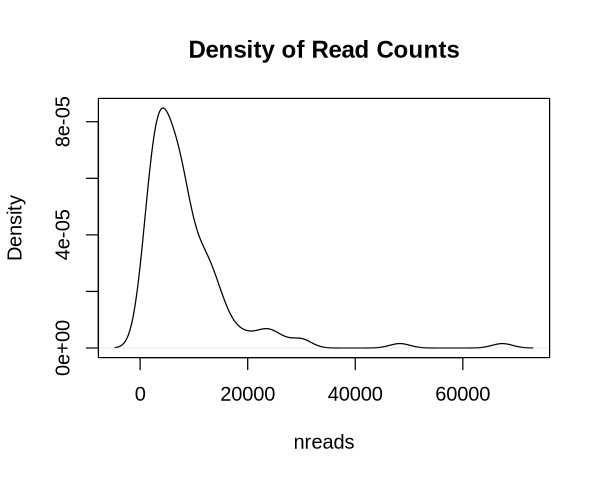

In [30]:
plot(density(dist_metadata_filt$nreads), main = "Density of Read Counts", xlab = "nreads")

In [31]:
# write.table(dist_metadata, file = "dist_metadata080425.tsv", sep = "\t", row.names = FALSE)

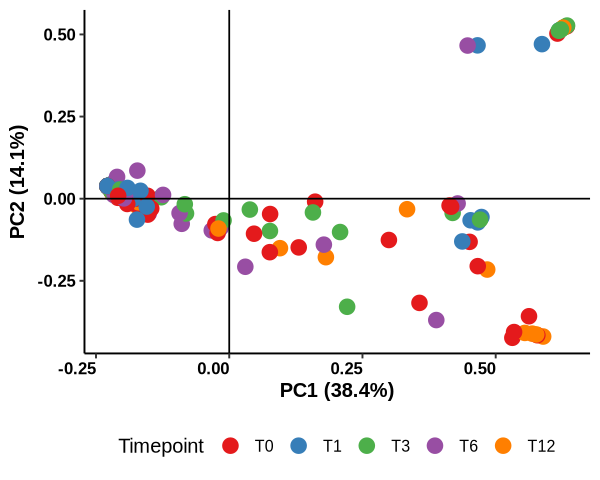

In [50]:
dist_metadata$Timepoint <- factor(dist_metadata$Timepoint, levels = c("T0", "T1", "T3", "T6", "T12"))

bray_curtis_time <- ggplot(data = dist_metadata, aes(x = pcoa1, y = pcoa2, color = Timepoint)) +
  geom_point(size = 4) +   
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  scale_color_manual(values = my_palette4timepoint) +  
  labs(
    x = paste0("PC1 (", var_exp1, "%)"),
    y = paste0("PC2 (", var_exp2, "%)")
  ) +
  theme_classic(base_size = 12) +
  theme(
    legend.position = "bottom",  # <--- add this line
    title = element_text(size = 12), 
    axis.text.x = element_text(hjust = 1, size = 10, colour = "black", face="bold"),
    axis.text.y = element_text(hjust = 1, size = 10, colour = "black", face="bold"),
    axis.text = element_text(size = 12, colour = "black", face="bold"),
    axis.title = element_text(size = 12, colour = "black", face="bold")
  )

bray_curtis_time

# Save the plot as a PNG file
ggsave("bray_curtis_time.png", plot = bray_curtis_time, width = 6, height = 4, dpi = 300)

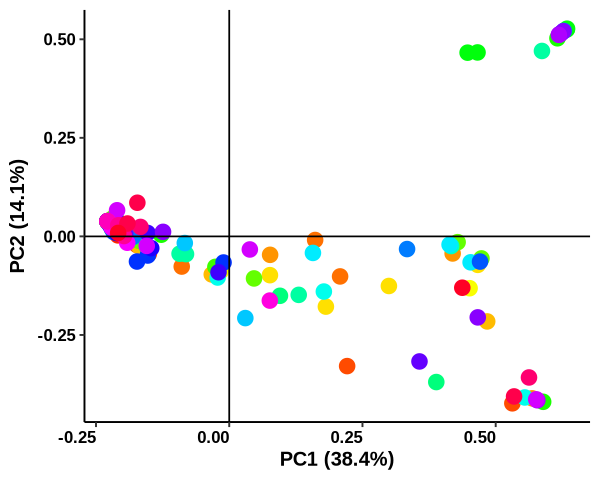

In [65]:
bray_curtis_patient <- ggplot(data = dist_metadata, aes(x = pcoa1, y = pcoa2, color = Patient)) +
  geom_point(size = 4) +   
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  scale_color_manual(values = my_palette4patients) +  
  labs(
    x = paste0("PC1 (", var_exp1, "%)"),
    y = paste0("PC2 (", var_exp2, "%)"),
  ) +
  guides(color = guide_legend(ncol = 3)) +  
  theme_classic(base_size = 12) +
  theme(
    legend.position = "none", 
    title = element_text(size = 10), 
    axis.text.x = element_text(hjust = 1, size = 10, colour = "black", face="bold"),
    axis.text.y = element_text(hjust = 1, size = 10, colour = "black", face="bold"),
    axis.text = element_text(size = 12, colour = "black", face="bold"),
    axis.title = element_text(size = 12, colour = "black", face="bold")
  )
bray_curtis_patient

# Save the plot as a PNG file
ggsave("bray_curtis_patient.png", plot = bray_curtis_patient, width = 8, height = 6, dpi = 300)

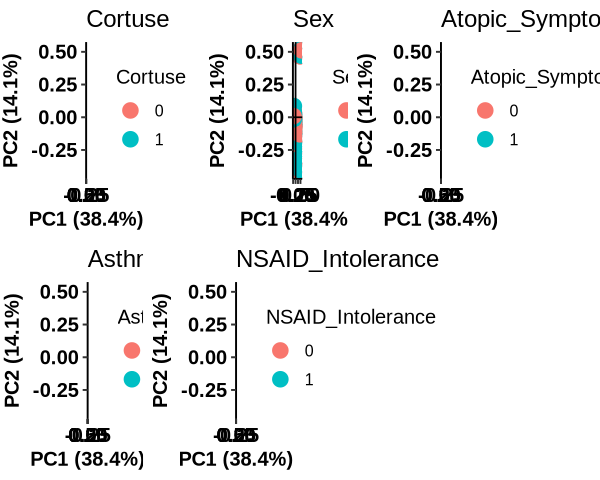

In [34]:
# Ploting PCoA using different metadata groups (boolean variables)
## List of categorical variables to use for coloring
color_vars <- c("Cortuse", "Sex", "Atopic_Symptoms", "Asthma", "NSAID_Intolerance")

## Generate multiple plots
plot_list <- lapply(color_vars, function(var) {
    ggplot(data = dist_metadata, aes(x = pcoa1, y = pcoa2, color = factor(!!sym(var)))) +
        geom_point(size = 4) +   
        # stat_ellipse(level = 0.8) +  # Uncomment if desired
        geom_hline(yintercept = 0) +
        geom_vline(xintercept = 0) +
        labs(
            x = paste0("PC1 (", var_exp1, "%)"),
            y = paste0("PC2 (", var_exp2, "%)"),
            color = var,  
            title = paste(var)
        ) +
  theme_classic(base_size = 12) +
        theme(
            title = element_text(size = 12),
            axis.text = element_text(size = 12, colour = "black", face = "bold"),
            axis.title = element_text(size = 12, colour = "black", face = "bold"),
            legend.position = "right"
        )
})

## Display the plots
p_all <- grid.arrange(grobs = plot_list, ncol = 3)

# Save the plot as a PNG file
ggsave("PCoA_boolean_vars.png", p_all, width = 14, height = 10, dpi = 300)

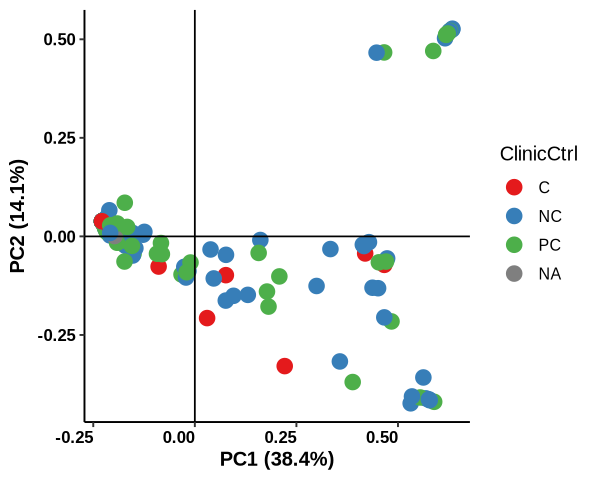

In [75]:
bray_curtis_ClinicCtrl <- ggplot(data = dist_metadata, aes(x = pcoa1, y = pcoa2, color = ClinicCtrl)) +
  geom_point(size = 4) +   
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  scale_color_manual(values = my_palette4timepoint) +  
  labs(
    x = paste0("PC1 (", var_exp1, "%)"),
    y = paste0("PC2 (", var_exp2, "%)"),
  ) +
  theme_classic(base_size = 12) +
  theme(
    # legend.position = "top",  
    title = element_text(size = 12), 
    axis.text.x = element_text(hjust = 1, size = 10, colour = "black", face = "bold"),
    axis.text.y = element_text(hjust = 1, size = 10, colour = "black", face = "bold"),
    axis.text = element_text(size = 12, colour = "black", face = "bold"),
    axis.title = element_text(size = 12, colour = "black", face = "bold")
  )

bray_curtis_ClinicCtrl

# Save the plot as a PNG file
ggsave("bray_curtis_ClinicCtrl.png", plot = bray_curtis_ClinicCtrl, width = 8, height = 6, dpi = 300)

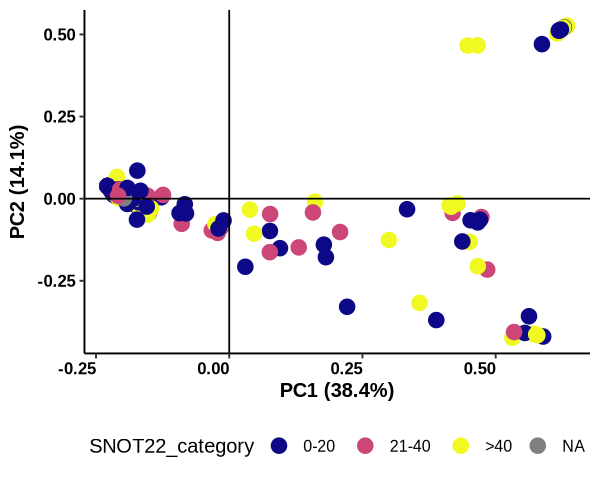

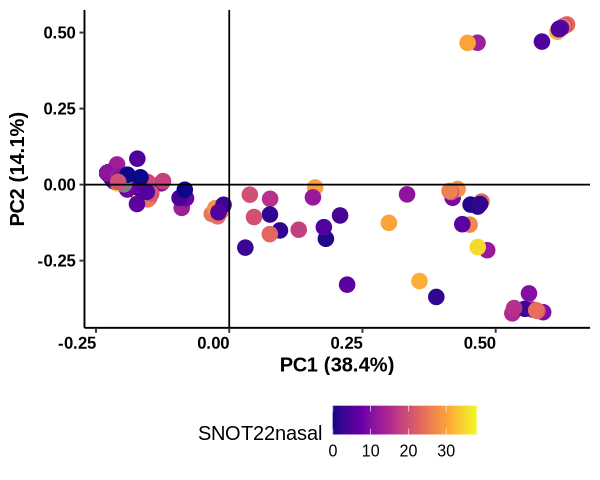

In [57]:
# Ploting PCoA using different metadata groups (numeric variables)

## SNOT22 (general x nasal)
dist_metadata$SNOT22_category <- cut(
  dist_metadata$SNOT22, 
  breaks = c(-Inf, 20, 40, Inf), 
  labels = c("0-20", "21-40", ">40")
)

# Custom color palette 
snot22_palette <- c("0-20" = "#0D0887", "21-40" = "#CC4778", ">40" = "#F0F921")

# Plot for SNOT22 (Categorical)
bray_curtis_snot22 <- ggplot(data = dist_metadata, aes(x = pcoa1, y = pcoa2, color = SNOT22_category)) +
  geom_point(size = 4) +   
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  scale_color_manual(values = snot22_palette) +
  labs(
    x = paste0("PC1 (", var_exp1, "%)"),
    y = paste0("PC2 (", var_exp2, "%)"),
  ) +
  theme_classic(base_size = 12) +
  theme(
    legend.position = "bottom", 
    title = element_text(size = 12), 
    axis.text.x = element_text(hjust = 1, size = 10, colour = "black", face = "bold"),
    axis.text.y = element_text(hjust = 1, size = 10, colour = "black", face = "bold"),
    axis.text = element_text(size = 12, colour = "black", face = "bold"),
    axis.title = element_text(size = 12, colour = "black", face = "bold")
  )

bray_curtis_snot22

# Save SNOT22 plot
ggsave("bray_curtis_snot22.png", plot = bray_curtis_snot22, width = 6, height = 4, dpi = 300)

# Plot for SNOT22nasal (Continuous)
bray_curtis_snot22nasal <- ggplot(data = dist_metadata, aes(x = pcoa1, y = pcoa2, color = SNOT22nasal)) +
  geom_point(size = 4) +   
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  scale_color_viridis_c(option = "plasma") +
  labs(
    x = paste0("PC1 (", var_exp1, "%)"),
    y = paste0("PC2 (", var_exp2, "%)"),
  ) +
  theme_classic(base_size = 12) +
  theme(
    legend.position = "bottom", 
    title = element_text(size = 12), 
    axis.text.x = element_text(hjust = 1, size = 10, colour = "black", face = "bold"),
    axis.text.y = element_text(hjust = 1, size = 10, colour = "black", face = "bold"),
    axis.text = element_text(size = 12, colour = "black", face = "bold"),
    axis.title = element_text(size = 12, colour = "black", face = "bold")
  )

bray_curtis_snot22nasal

# Save SNOT22nasal plot
ggsave("bray_curtis_snot22nasal.png", plot = bray_curtis_snot22nasal, width = 6, height = 4, dpi = 300)

# Combine both plots
combined_SNOTplot <- ggarrange(
  bray_curtis_snot22, bray_curtis_snot22nasal, 
  labels = c("A", "B"),
  ncol = 2, nrow = 1,
  common.legend = FALSE
)

combined_SNOTplot

# Save combined plot
ggsave("combined_SNOTplot.png", plot = combined_SNOTplot, width = 10, height = 8, dpi = 300)

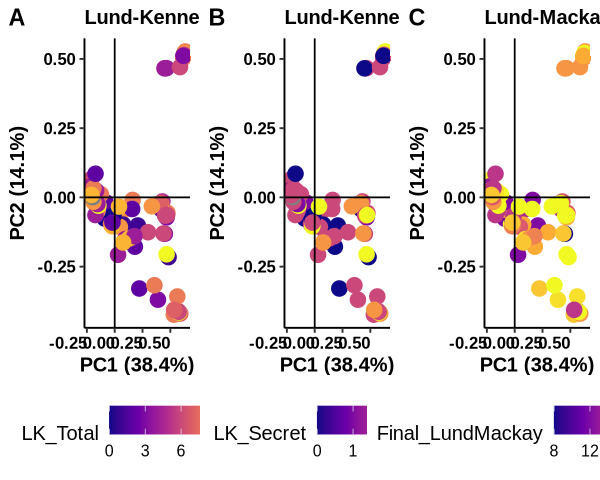

In [86]:
# Plot for LK_Total (Continuous)
bray_curtis_LKtotal <- ggplot(data = dist_metadata, aes(x = pcoa1, y = pcoa2, color = LK_Total)) +
  geom_point(size = 4) +   
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  scale_color_viridis_c(option = "plasma") +
  labs(
    x = paste0("PC1 (", var_exp1, "%)"),
    y = paste0("PC2 (", var_exp2, "%)"),
    title = "Lund-Kennedy Total"
  ) +
  theme_classic(base_size = 12) +
    theme(
    legend.position = "bottom", 
    plot.title = element_text(size = 12, face = "bold"),
    axis.text.x = element_text(hjust = 1, size = 10, colour = "black", face = "bold"),
    axis.text.y = element_text(hjust = 1, size = 10, colour = "black", face = "bold"),
    axis.title = element_text(size = 12, colour = "black", face = "bold")
  )

ggsave("bray_curtis_LKtotal.png", plot = bray_curtis_LKtotal, width = 6, height = 4, dpi = 300)

# Plot for LK_Secret (Continuous)
bray_curtis_LKsecret <- ggplot(data = dist_metadata, aes(x = pcoa1, y = pcoa2, color = LK_Secret)) +
  geom_point(size = 4) +   
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  scale_color_viridis_c(option = "plasma") +
  labs(
    x = paste0("PC1 (", var_exp1, "%)"),
    y = paste0("PC2 (", var_exp2, "%)"),
    title = "Lund-Kennedy Secretion"
  ) +
  theme_classic(base_size = 12) +
  theme(
    legend.position = "bottom",  
    plot.title = element_text(size = 12, face = "bold"),
    axis.text.x = element_text(hjust = 1, size = 10, colour = "black", face = "bold"),
    axis.text.y = element_text(hjust = 1, size = 10, colour = "black", face = "bold"),
    axis.title = element_text(size = 12, colour = "black", face = "bold")
  )

ggsave("bray_curtis_LKsecret.png", plot = bray_curtis_LKsecret, width = 6, height = 4, dpi = 300)

# Plot for Final_LundMackay (Continuous)
bray_curtis_LKfinal <- ggplot(data = dist_metadata, aes(x = pcoa1, y = pcoa2, color = Final_LundMackay)) +
  geom_point(size = 4) +   
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  scale_color_viridis_c(option = "plasma") +
  labs(
    x = paste0("PC1 (", var_exp1, "%)"),
    y = paste0("PC2 (", var_exp2, "%)"),
    title = "Lund-Mackay Final"
  ) +
  theme_classic(base_size = 12) +
theme(
    legend.position = "bottom",  
    plot.title = element_text(size = 12, face = "bold"),
    axis.text.x = element_text(hjust = 1, size = 10, colour = "black", face = "bold"),
    axis.text.y = element_text(hjust = 1, size = 10, colour = "black", face = "bold"),
    axis.title = element_text(size = 12, colour = "black", face = "bold")
  )

ggsave("bray_curtis_LKfinal.png", plot = bray_curtis_LKfinal, width = 6, height = 4, dpi = 300)

# Combine the plots into one figure
combined_LKplot <- ggarrange(
  bray_curtis_LKtotal, 
  bray_curtis_LKsecret, 
  bray_curtis_LKfinal, 
  labels = c("A", "B", "C"),
  ncol = 3, nrow = 1,
  common.legend = FALSE
)

combined_LKplot

ggsave("combined_LKplot.png", plot = combined_LKplot, width = 14, height = 6, dpi = 300)

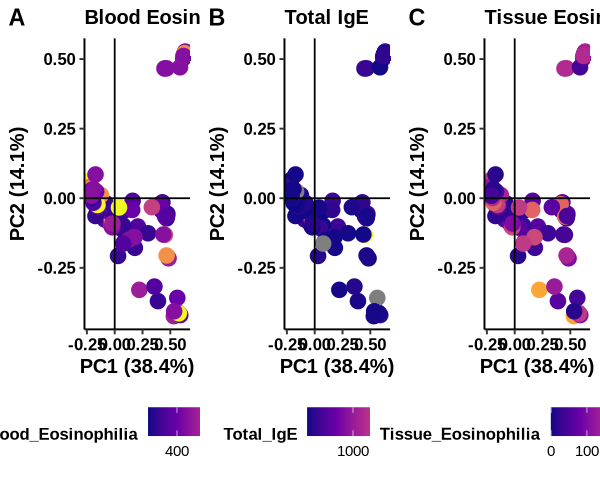

In [83]:
# Define axis labels
xlab <- paste0("PC1 (", var_exp1, "%)")
ylab <- paste0("PC2 (", var_exp2, "%)")

# Plot for Serum Eosinophilia
bray_curtis_eosinofilia <- ggplot(data = dist_metadata, aes(x = pcoa1, y = pcoa2, color = Blood_Eosinophilia)) +
  geom_point(size = 4) +   
  geom_hline(yintercept = 0, linetype = "solid") +
  geom_vline(xintercept = 0, linetype = "solid") +
  scale_color_viridis_c(option = "plasma") +
  labs(x = xlab, y = ylab, title = "Blood Eosinophils") +
  theme_classic(base_size = 12) +
  theme(
    legend.position = "bottom",  
    plot.title = element_text(size = 12, face = "bold"),
    axis.text = element_text(size = 10, colour = "black", face = "bold"),
    axis.title = element_text(size = 12, face = "bold"),
    legend.title = element_text(size = 10, face = "bold"),
    legend.text = element_text(size = 9)
  )

ggsave("bray_curtis_eosinofilia.png", plot = bray_curtis_eosinofilia, width = 6, height = 4, dpi = 300)

# Plot for Total IgE
bray_curtis_ige <- ggplot(data = dist_metadata, aes(x = pcoa1, y = pcoa2, color = Total_IgE)) +
  geom_point(size = 4) +   
  geom_hline(yintercept = 0, linetype = "solid") +
  geom_vline(xintercept = 0, linetype = "solid") +
  scale_color_viridis_c(option = "plasma") +
  labs(x = xlab, y = ylab, title = "Total IgE") +
  theme_classic(base_size = 12) +
  theme(
    legend.position = "bottom",  
    plot.title = element_text(size = 12, face = "bold"),
    axis.text = element_text(size = 10, colour = "black", face = "bold"),
    axis.title = element_text(size = 12, face = "bold"),
    legend.title = element_text(size = 10, face = "bold"),
    legend.text = element_text(size = 9)
  )

ggsave("bray_curtis_ige.png", plot = bray_curtis_ige, width = 6, height = 4, dpi = 300)

# Plot for Tissue Eosinophilia
bray_curtis_eos_teciduais <- ggplot(data = dist_metadata, aes(x = pcoa1, y = pcoa2, color = Tissue_Eosinophilia)) +
  geom_point(size = 4) +   
  geom_hline(yintercept = 0, linetype = "solid") +
  geom_vline(xintercept = 0, linetype = "solid") +
  scale_color_viridis_c(option = "plasma") +
  labs(x = xlab, y = ylab, title = "Tissue Eosinophils") +
  theme_classic(base_size = 12) +
  theme(
    legend.position = "bottom",  
    plot.title = element_text(size = 12, face = "bold"),
    axis.text = element_text(size = 10, colour = "black", face = "bold"),
    axis.title = element_text(size = 12, face = "bold"),
    legend.title = element_text(size = 10, face = "bold"),
    legend.text = element_text(size = 9)
  )

ggsave("bray_curtis_eos_teciduais.png", plot = bray_curtis_eos_teciduais, width = 6, height = 4, dpi = 300)

# Combine the three plots into one figure
combined_extra_plot <- ggarrange(
  bray_curtis_eosinofilia,
  bray_curtis_ige,
  bray_curtis_eos_teciduais,
  labels = c("A", "B", "C"),
  ncol = 3, nrow = 1,
  common.legend = FALSE
)

combined_extra_plot

ggsave("combined_extra_plot.png", combined_extra_plot, width = 14, height = 6, dpi = 300)

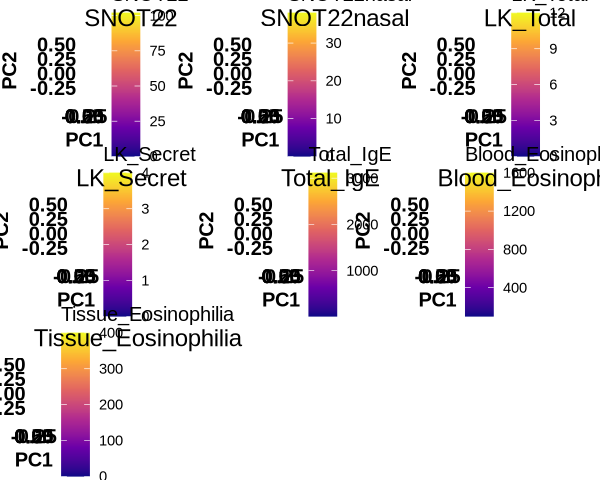

In [21]:
# Ploting PCoA using different metadata groups (numeric variables)
## List of numeric variables to use for coloring
numeric_vars <- c("SNOT22", "SNOT22nasal", "LK_Total", "LK_Secret", 
                  "Total_IgE", "Blood_Eosinophilia", "Tissue_Eosinophilia")

## Generate multiple PCoA plots with numeric color scales
plot_list <- lapply(numeric_vars, function(var) {
    ggplot(data = dist_metadata_filt, aes(x = pcoa1, y = pcoa2, color = !!sym(var))) +
        geom_point(size = 4) +   
        #stat_ellipse(level = 0.8) +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_vline(xintercept = 0, linetype = "dashed") +
        scale_color_viridis_c(option = "plasma") +  # Use a continuous color scale (viridis)
        labs(x = "PC1",
             y = "PC2", 
             color = var,  # Legend label
             title = paste(var)) +
        theme_minimal() +
        theme(
            title = element_text(size = 12),
            axis.text = element_text(size = 12, colour = "black", face = "bold"),
            axis.title = element_text(size = 12, colour = "black", face = "bold"),
            legend.position = "right"
        )
})

## Display the plots
grid.arrange(grobs = plot_list, ncol = 3)

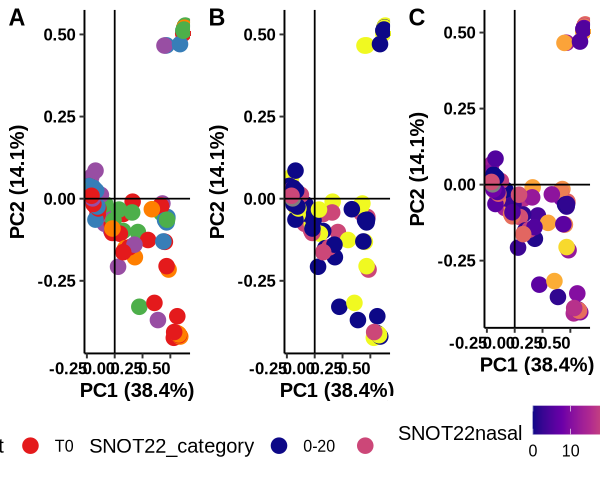

In [59]:
# Combine into one figure
combined_extra_plot2 <- ggarrange(
  bray_curtis_time,
  bray_curtis_snot22,
  bray_curtis_snot22nasal,  
  labels = c("A", "B", "C"),
  ncol = 3, nrow = 1,
  common.legend = FALSE
)

combined_extra_plot2

In [62]:
ggsave("combined_extra_plot2.png", combined_extra_plot2, width = 14, height = 6, dpi = 300)

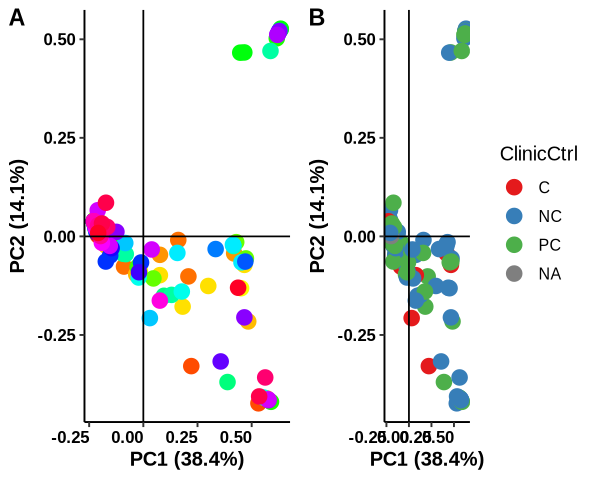

In [76]:
# Combine into one figure
combined_extra_plot3 <- ggarrange(
  bray_curtis_patient,
  bray_curtis_ClinicCtrl,
  labels = c("A", "B", "C"),
  ncol = 2, nrow = 1,
  common.legend = FALSE
)

combined_extra_plot3

In [77]:
ggsave("combined_extra_plot3.png", combined_extra_plot3, width = 12, height = 6, dpi = 300)